In [2]:
from helperClasses.DataPipeline import DataPipeline
from helperClasses.BaseTransformation import BaseTransformation
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

## SVO-File laden##
Die SVO-Dateien bitte nicht auf GIT pushen, da diese sehr groß sind. Jelle arbeitet an einer Lösung. Bis dann die SVO-Dateien mit lokalem Pfad laden.

In [3]:
svo_path = '../data/HD1080_SN35520970_11-03-24.svo'

**Methode zum zeichnen des Tennisfeldes**
Ist eine Hilfsmethode, die das Tennisfeld zeichnet. Kannst du ignorieren.

In [4]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.41, 6.39], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

## Datenaufbereitung ## 
Wenn du die Daten neu berechnen möchtest und nicht aus der vorhandenen CSV-Datei laden möchtest, dann führe die folgende Zelle aus. Ansonsten kannst du die darunterliegende Zelle ausführen.

In [5]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]
detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

detected_objects_list = []

while zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    # Retrieve objects
    zed.retrieve_objects(detected_objects, detection_parameters_rt)

    frame_nr = zed.get_svo_position()

    for i, obj in enumerate(detected_objects.object_list):
        if obj.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
            detected_objects_list.append({
                'obj': obj,
                'obj_nr': i,
                'frame_nr': frame_nr
            })
df_detected_objects = pd.DataFrame(
    data=[
        [
            obj['frame_nr'],
            obj['obj_nr'],
            obj['obj'].id,
            obj['obj'].label,
            obj['obj'].confidence,
            obj['obj'].tracking_state,
            obj['obj'].position[0],
            obj['obj'].position[1],
            obj['obj'].position[2],
            obj['obj'].velocity[0],
            obj['obj'].velocity[1],
            obj['obj'].velocity[2],
            obj['obj'].dimensions[0],
            obj['obj'].dimensions[1],
            obj['obj'].dimensions[2]
        ] for obj in detected_objects_list
    ],
    columns=['frame', 'object', 'object_id', 'object_label', 'confidence', 'tracking_state', 'x', 'y', 'z', 'vx', 'xy',
             'vz', 'width', 'height', 'length']
)
df_detected_objects.to_csv('df_detected_objects.csv', index=False, float_format='%.5f')

NameError: name 'sl' is not defined

In [6]:
data = pd.read_csv('df_detected_objects.csv') # Daten aus der CSV-Datei laden


calibration_points = np.array([
    [0.404, -1.434, -13.462], # service line center
    [3.263, -1.300, -11.118], # service x singles sideline
    [0.446, -1.444, -7.882] # baseline x singles sideline
])
bt = BaseTransformation(calibration_points)
data = bt.transformData(data, [-1.5, 0, -18.28])

dp = DataPipeline()
data = dp.mergePersons(data, 0.7, 0.1)

In [7]:
data

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length
1,3,1,1,Person,58.69141,OK,0.491703,-1.808712,13.248981,-3.77620,0.20816,-10.44296,0.79609,1.36517,0.79609
3,4,1,1,Person,57.95898,OK,0.545964,-1.802297,13.155637,-2.49269,0.16367,-8.05950,0.78589,1.36619,0.78589
5,5,1,1,Person,55.90820,OK,0.490332,-1.803161,13.285841,-1.44754,0.09919,-4.91755,0.77365,1.37026,0.77365
7,6,1,1,Person,50.00000,OK,0.491634,-1.801160,13.310953,-1.10440,0.07878,-3.91267,0.75425,1.37394,0.75425
9,7,1,1,Person,37.01172,OK,0.444338,-1.802547,13.393477,-0.81841,0.05096,-2.55268,0.73128,1.37605,0.73128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,10325,0,6,Person,90.03906,OK,7.807464,-0.848574,-17.006798,0.02334,0.00220,-0.09401,0.49989,0.31608,0.49989
25383,10326,0,6,Person,90.23438,OK,7.808461,-0.848025,-17.007186,0.02275,0.00216,-0.09162,0.49989,0.31417,0.49989
25385,10327,0,6,Person,90.23438,OK,7.809351,-0.847470,-17.007518,0.02215,0.00209,-0.08922,0.49990,0.31232,0.49990
25387,10328,0,6,Person,90.08789,OK,7.810077,-0.846933,-17.007788,0.02148,0.00201,-0.08652,0.49990,0.31056,0.49990


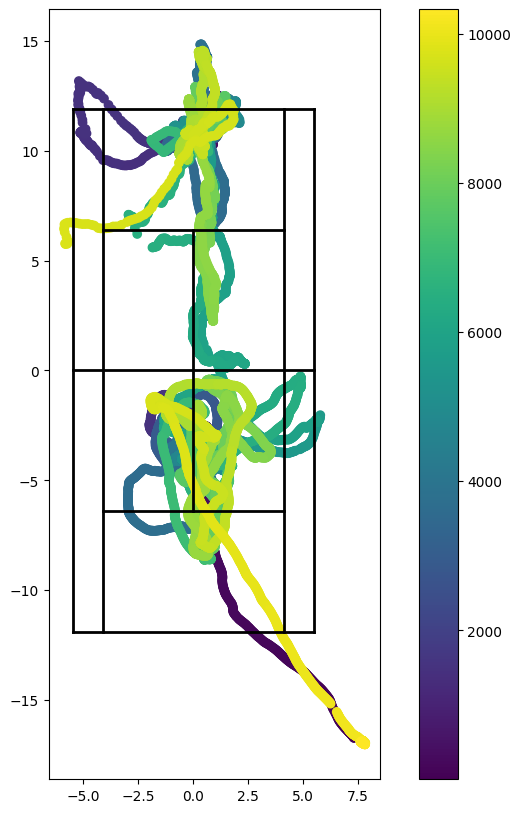

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=data['x'], y=data['z'], c=data['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

## EDA ##